##### Promoter Designer Evaluation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.functional import one_hot

from matplotlib import pyplot as plt
%matplotlib inline

import rpy2
import functools
import numpy as np
import pandas as pd
import pyBigWig
import tabix

import selene_sdk
from selene_sdk.utils import NonStrandSpecific
from selene_sdk.targets import Target

import sys
sys.path.append("../")
sys.path.append("../external")

from ddsm import * 
from sei import *
from selene_utils import *


In [38]:
class ModelParameters:
    seifeatures_file = '../data/promoter_design/target.sei.names'
    seimodel_file = '../data/promoter_design/best.sei.model.pth.tar'

    ref_file = '../data/promoter_design/Homo_sapiens.GRCh38.dna.primary_assembly.fa'
    ref_file_mmap = '../data/promoter_design/Homo_sapiens.GRCh38.dna.primary_assembly.fa.mmap'
    tsses_file = '../data/promoter_design/FANTOM_CAT.lv3_robust.tss.sortedby_fantomcage.hg38.v4.tsv'

    fantom_files = [
                    "../data/promoter_design/agg.plus.bw.bedgraph.bw",
                    "../data/promoter_design/agg.minus.bw.bedgraph.bw"
                    ]

    fantom_blacklist_files = [
         "../data/promoter_design/fantom.blacklist8.plus.bed.gz",
         "../data/promoter_design/fantom.blacklist8.minus.bed.gz"
        ]

    device = 'cuda'
    batch_size = 16
    num_workers = 4
    
    num_epochs = 200

    lr = 5e-4

    #Beta Diffusion Parameters:
    eta = 10000.0
    sigmoid_start = 10.0
    sigmoid_end = -13.0
    sigmoid_power = 0.2
    Scale = 0.5
    Shift = 0.4
    KLUB_Scale = 0.5
    KLUB_Shift =0.4
    lossType = "KLUB"
    batch_size = 256    
    normalize_output = True

In [3]:
torch.set_default_dtype(torch.float32)

In [4]:
class GenomicSignalFeatures(Target):
    """
    #Accept a list of cooler files as input.
    """
    def __init__(self, input_paths, features, shape, blacklists=None, blacklists_indices=None, 
        replacement_indices=None, replacement_scaling_factors=None):
        """
        Constructs a new `GenomicFeatures` object.
        """
        self.input_paths = input_paths
        self.initialized = False
        self.blacklists_file = blacklists
        self.blacklists_indices = blacklists_indices
        self.replacement_indices = replacement_indices
        self.replacement_scaling_factors = replacement_scaling_factors

        self.n_features = len(features)
        self.feature_index_dict = dict(
            [(feat, index) for index, feat in enumerate(features)])
        self.shape = (len(input_paths), *shape)

    def get_feature_data(self, chrom, start, end, nan_as_zero=True, feature_indices=None):
        if not self.initialized:
            self.data = [pyBigWig.open(path) for path in self.input_paths]
            if self.blacklists_file is not None:
                self.blacklists = [tabix.open(blacklist) for blacklist in self.blacklists_file]
            self.initialized=True

        if feature_indices is None:
            feature_indices = np.arange(len(self.data))

        wigmat = np.zeros((len(feature_indices), end - start), dtype=np.float32)
        for i in feature_indices:
            try:
                wigmat[i, :] = self.data[i].values(chrom, start, end, numpy=True)
            except:
                print(chrom, start, end, self.input_paths[i], flush=True)
                raise
        
        if self.blacklists is not None:
            if self.replacement_indices is None:
                if self.blacklists_indices is not None:
                    for blacklist, blacklist_indices in zip(self.blacklists, self.blacklists_indices):
                        for _, s, e in blacklist.query(chrom, start, end):
                            wigmat[blacklist_indices, np.fmax(int(s)-start,0): int(e)-start] = 0
                else:
                    for blacklist in self.blacklists:
                        for _, s, e in blacklist.query(chrom, start, end):
                            wigmat[:, np.fmax(int(s)-start,0): int(e)-start] = 0
            else:
                for blacklist, blacklist_indices, replacement_indices, replacement_scaling_factor in zip(self.blacklists, self.blacklists_indices, self.replacement_indices, self.replacement_scaling_factors):
                    for _, s, e in blacklist.query(chrom, start, end):
                        wigmat[blacklist_indices, np.fmax(int(s)-start,0): int(e)-start] = wigmat[replacement_indices, np.fmax(int(s)-start,0): int(e)-start] * replacement_scaling_factor

        if nan_as_zero:
            wigmat[np.isnan(wigmat)]=0
        return wigmat

    
class TSSDatasetS(Dataset):
    def __init__(self, config, seqlength=1024, split="train", n_tsses=100000, rand_offset=0):
        self.shuffle = False

        self.genome = MemmapGenome(
            input_path=config.ref_file,
            memmapfile=config.ref_file_mmap,
            blacklist_regions='hg38'
        )
        self.tfeature = GenomicSignalFeatures(
            config.fantom_files,
            ['cage_plus', 'cage_minus'],
            (2000,),
            config.fantom_blacklist_files
        )

        self.tsses = pd.read_table(config.tsses_file, sep='\t')
        self.tsses = self.tsses.iloc[:n_tsses, :]

        self.chr_lens = self.genome.get_chr_lens()
        self.split = split
        if split == "train":
            self.tsses = self.tsses.iloc[~np.isin(self.tsses['chr'].values, ['chr8', 'chr9', 'chr10'])]
        elif split == "valid":
            self.tsses = self.tsses.iloc[np.isin(self.tsses['chr'].values, ['chr10'])]
        elif split == "test":
            self.tsses = self.tsses.iloc[np.isin(self.tsses['chr'].values, ['chr8', 'chr9'])]
        else:
            raise ValueError
        self.rand_offset = rand_offset
        self.seqlength = seqlength

    def __len__(self):
        return self.tsses.shape[0]

    def __getitem__(self, tssi):
        chrm, pos, strand = self.tsses['chr'].values[tssi], self.tsses['TSS'].values[tssi], self.tsses['strand'].values[
            tssi]
        offset = 1 if strand == '-' else 0

        offset = offset + np.random.randint(-self.rand_offset, self.rand_offset + 1)
        seq = self.genome.get_encoding_from_coords(chrm, pos - int(self.seqlength / 2) + offset,
                                                   pos + int(self.seqlength / 2) + offset, strand)

        signal = self.tfeature.get_feature_data(chrm, pos - int(self.seqlength / 2) + offset,
                                                pos + int(self.seqlength / 2) + offset)
        if strand == '-':
            signal = signal[::-1, ::-1]
        return np.concatenate([seq, signal.T], axis=-1).astype(np.float32)

    def reset(self):
        np.random.seed(0)

In [92]:
class Dense(nn.Module):
    """
    A fully connected layer that reshapes outputs to feature maps.
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[...]

    
class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, embed_dim=256, time_dependent_weights=None, time_step=0.01):
    """
    Initialize a time-dependent score-based network.
    Args:
      marginal_prob_std: A function that takes time t and gives the standard
      deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    
    n=256
    self.linear = nn.Conv1d(5, n, kernel_size=9, padding=4)
    self.blocks = nn.ModuleList([nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, dilation=4, padding=16),
                nn.Conv1d(n, n, kernel_size=9, dilation=16, padding=64),
                nn.Conv1d(n, n, kernel_size=9, dilation=64, padding=256),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, dilation=4, padding=16),
                nn.Conv1d(n, n, kernel_size=9, dilation=16, padding=64),
                nn.Conv1d(n, n, kernel_size=9, dilation=64, padding=256),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, dilation=4, padding=16),
                nn.Conv1d(n, n, kernel_size=9, dilation=16, padding=64),
                nn.Conv1d(n, n, kernel_size=9, dilation=64, padding=256),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, dilation=4, padding=16),
                nn.Conv1d(n, n, kernel_size=9, dilation=16, padding=64),
                nn.Conv1d(n, n, kernel_size=9, dilation=64, padding=256)])



    self.denses = nn.ModuleList([Dense(embed_dim, n) for _ in range(20)])
    self.norms = nn.ModuleList([nn.GroupNorm(1,n) for _ in range(20)])

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.relu = nn.ReLU()
    self.softplus = nn.Softplus()
    self.scale = nn.Parameter(torch.ones(1))
    self.final =  nn.Sequential(nn.Conv1d(n, n, kernel_size=1),
                                nn.GELU(),
                                nn.Conv1d(n, 4, kernel_size=1))
    self.register_buffer("time_dependent_weights", time_dependent_weights)
    self.time_step = time_step
    
  def forward(self, x, t, t_ind=None, return_a=False):
    # Obtain the Gaussian random feature embedding for t
    # embed: [N, embed_dim]
    embed = self.act(self.embed(t/2))

    # Encoding path
    # x: NLC -> NCL
    out = x.permute(0, 2, 1)
    out = self.act(self.linear(out))
    
    #pos encoding
    for block, dense, norm in zip(self.blocks, self.denses, self.norms):
        h = self.act(block(norm(out + dense(embed)[:,:,None])))
        if h.shape == out.shape:
            out = h + out
        else:
            out = h

    
    out = self.final(out)
    out = out.permute(0, 2, 1)
    if self.time_dependent_weights is not None:
        t_step = (t/self.time_step)-1
        w0 = self.time_dependent_weights[t_step.long()]
        w1 = self.time_dependent_weights[torch.clip(t_step+1,max=len(self.time_dependent_weights)-1).long()]
        out = out * (w0 + (t_step-t_step.floor())*(w1-w0))[:,None,None]

    out = out - out.mean(axis=-1, keepdims=True)
    return out

class BetaDiffPrecond(torch.nn.Module):
#class BetaDiffusionPrecond(torch.nn.Module):
    def __init__(self,
        # img_resolution,                 # Image resolution.
        # img_channels,                   # Number of color channels.
        # label_dim       = 0,            # Number of class labels, 0 = unconditional.
        use_fp16        = False,        # Execute the underlying model at FP16 precision?
        M               = 1000,         # Original number of timesteps in the DDPM formulation.
        epsilon_t       = 1e-5,         # Minimum t-value used during training.
        #model_type      = 'SongUNet',   # Class name of the underlying model.
        
        model_type      = 'None',   # Class name of the underlying model.
        **model_kwargs,                 # Keyword arguments for the underlying model.
    ):
        super().__init__()
        # self.img_resolution = img_resolution
        # self.img_channels = img_channels
        # self.label_dim = label_dim
        self.use_fp16 = use_fp16
        self.M = M
        self.epsilon_t = epsilon_t
        # self.model = globals()[model_type](img_resolution=img_resolution, in_channels=img_channels, out_channels=img_channels, label_dim=label_dim, **model_kwargs)
        self.model = ScoreNet()

    def forward(self, x, logit_alpha, class_labels=None, force_fp32=False, **model_kwargs):
        x = x.to(torch.float32)
        logit_alpha = logit_alpha.to(torch.float32).reshape(-1, 1, 1)
        # class_labels = None if self.label_dim == 0 else torch.zeros([1, self.label_dim], device=x.device) if class_labels is None else class_labels.to(torch.float32).reshape(-1, self.label_dim)
        #dtype = torch.float16 if (self.use_fp16 and not force_fp32 and x.device.type == 'cuda') else torch.float32
        dtype = torch.float32
        c_skip = 1
        c_out = 1
        #c_out = -sigma
        #c_in = 1 / (sigma ** 2 + 1).sqrt()
        
        c_noise = -logit_alpha/8.0

        #F_x = self.model((c_in * x).to(dtype), c_noise.flatten(), class_labels=class_labels, **model_kwargs)
        # F_x = self.model( x.to(dtype), c_noise.flatten(), class_labels=class_labels, **model_kwargs)
        #Check correctness
        # print("c_noise", c_noise.shape)
        F_x = self.model(torch.cat([x, class_labels], -1), c_noise[:, 0, 0])
        assert F_x.dtype == dtype
        #D_x = c_skip * x + c_out * F_x.to(torch.float32)
        #D_x = F_x.to(torch.float32)
        #D_x = c_skip*x + c_out*F_x.to(torch.float32)
        D_x = x + F_x.to(torch.float32)
        return D_x   

    def round_sigma(self, sigma):
        return torch.as_tensor(sigma)

In [122]:
from torch.nn.functional import logsigmoid

def bd_sampler(
    net, latents, class_labels=None, randn_like=torch.randn_like,
    num_steps=None, alpha_min=None, eta=None, sigmoid_start=None, sigmoid_end=None, sigmoid_power=None, start_step=None,Scale=None,Shift=None,normalize_output = True
):

    cust_dtype = torch.float64
    if num_steps>350:
    # if 1:
        step_indices = torch.arange(num_steps, dtype=cust_dtype, device=latents.device)

        t_steps = 1-step_indices / (num_steps - 1)*(1-1e-5)

        #t_steps = 0.996**(step_indices / (num_steps - 1)*500)

        # epsilon_s = 1e-5                
        # t_steps =  (epsilon_s + step_indices/(num_steps-1) * (1.0 - epsilon_s)).flip(dims=(0,))

        t_steps = torch.cat([net.module.round_sigma(t_steps), torch.zeros_like(t_steps[:1])])

        logit_alpha = sigmoid_start + (sigmoid_end-sigmoid_start) * (t_steps**sigmoid_power)
        alpha = logit_alpha.sigmoid()
    
    else:
        step_indices = torch.arange(num_steps+1, dtype=cust_dtype, device=latents.device)
        log_pi = (sigmoid_start + (sigmoid_end - sigmoid_start) * (torch.tensor(1, dtype=cust_dtype, device=latents.device)**sigmoid_power)).sigmoid().log() / (num_steps)
        #log_pi = torch.tensor(2e-6, device=latents.device).log()/(num_steps)
        alpha = (step_indices*log_pi).exp()
        alpha = torch.flip(alpha, [0])
        logit_alpha = alpha.logit()
        

    alpha_min = alpha_min if alpha_min is not None else alpha[0]
    # print("alpha_min", alpha_min)
    if 1:
        log_u = log_gamma( (eta * alpha_min * latents).to(torch.float32) ).to(cust_dtype)
        log_v = log_gamma( (eta - eta * alpha_min * latents).to(torch.float32) ).to(cust_dtype)
        x_next = (log_u - log_v).to(latents.device)
    else:
        x_next = torch.logit( alpha_min*latents.to(cust_dtype) ).to(latents.device)

    # if 1:
    #     x_next =x_next.clamp(torch.log( torch.tensor(MIN,device=latents.device)))

    # Main sampling loop.
    ims = []
    im_xhats = []
    for i, (logit_alpha_cur,logit_alpha_next) in enumerate(zip(logit_alpha[:-1], logit_alpha[1:])): # 0, ..., N-1
        x_cur = x_next
        alpha_cur = logit_alpha_cur.sigmoid()
        alpha_next = logit_alpha_next.sigmoid()

        log_alpha_cur = logsigmoid(logit_alpha_cur)

        xmin = Shift
        xmax = Shift + Scale
        xmean = Shift+Scale/2.0
        
        E1 = 1.0/(eta*alpha_cur*Scale)*((eta * alpha_cur * xmax).lgamma() - (eta * alpha_cur * xmin).lgamma())
        E2 = 1.0/(eta*alpha_cur*Scale)*((eta-eta * alpha_cur * xmin).lgamma() - (eta-eta * alpha_cur * xmax).lgamma())
        E_logit_x_t =  E1 - E2


        V1 = 1.0/(eta*alpha_cur*Scale)*((eta * alpha_cur * xmax).digamma() - (eta * alpha_cur * xmin).digamma())
        V2 = 1.0/(eta*alpha_cur*Scale)*((eta-eta * alpha_cur * xmin).digamma() - (eta-eta * alpha_cur * xmax).digamma())

        grids = (torch.arange(0,101,device=latents.device)/100 +0.5/100)*Scale+Shift
        grids = grids[:-1]
        alpha_x = alpha_cur*grids 
        if 1:
            #V3 = (((eta * alpha_cur * xmean).digamma())**2- E1**2).clamp(0)
            #V4 = (((eta-eta * alpha_cur * xmean).digamma())**2- E2**2).clamp(0)
            #V3 = E1**2
            #V4 = E2**2
            grids = (torch.arange(0,101,device=latents.device)/100)*Scale+Shift
            alpha_x = alpha_cur*grids 
            V3 = ((eta * alpha_x).digamma())**2
            #print(V3.shape)
            V3[0] = (V3[0]+V3[-1])/2
            V3 = V3[:-1]
            V3 = (V3.mean()- E1**2).clamp(0)   
            V4 = ((eta - eta*alpha_x).digamma())**2
            V4[0] = (V4[0]+V4[-1])/2
            V4 = V4[:-1]
            V4 = (V4.mean()- E2**2).clamp(0)
            
            #V3 = (( ((eta * alpha_x).digamma())**2).mean()- E1**2).clamp(0)           
            #V4 = (( ((eta - eta*alpha_x).digamma())**2).mean()- E2**2).clamp(0)
        else:
            V3 = (( ((eta * alpha_x).digamma())**2).mean()- E1**2).clamp(0)           
            V4 = (( ((eta - eta*alpha_x).digamma())**2).mean()- E2**2).clamp(0)


        std_logit_x_t = (V1+V2+V3+V4).sqrt()
        
        #std_logit_x_t = std_logit_x_t.clamp(EPS)

        logit_x_t = x_cur
        # print("(logit_x_t-E_logit_x_t)/std_logit_x_t", ((logit_x_t-E_logit_x_t)/std_logit_x_t).shape)
        # print("logit_alpha_cur", logit_alpha_cur.shape)
        # print("class_labels", class_labels.shape)
        if class_labels is None:
            logit_x0_hat = net((logit_x_t-E_logit_x_t)/std_logit_x_t, logit_alpha_cur.unsqueeze(0).repeat(logit_x_t.shape[0])).to(cust_dtype)
        else:    
            logit_x0_hat = net((logit_x_t-E_logit_x_t)/std_logit_x_t, logit_alpha_cur.unsqueeze(0).repeat(logit_x_t.shape[0]), class_labels).to(cust_dtype)
            
        if normalize_output:

            variance = (1/4) * (torch.polygamma(1, eta * alpha_cur * (Scale + Shift)) - torch.polygamma(1, eta * (1- alpha_cur * (Scale+Shift)))) + \
                    (3/4) * (torch.polygamma(1, eta * alpha_cur * Shift) - torch.polygamma(1, eta * (1 - alpha_cur * Shift))) + \
                    (3/16) * ((torch.special.digamma(eta * alpha_cur * (Scale + Shift)) - torch.special.digamma(eta * (1 - alpha_cur * (Scale + Shift)))) - \
                                (torch.special.digamma(eta * alpha_cur * Shift) - torch.special.digamma(eta * (1 - alpha_cur * Shift))))**2

            std = torch.clamp(torch.sqrt(variance) * (eta * alpha_cur * Scale), max = 20)

            # mean = (1/4) * (torch.special.digamma(eta * alpha_cur * (Scale + Shift)) - torch.special.digamma(eta * (1- alpha_cur * (Scale+Shift)))) + \
            #         (3/4) * (torch.special.digamma(eta * alpha_cur * Shift) - torch.special.digamma(eta * (1 - alpha_cur * Shift)))

            # mean = mean * (eta * alpha_cur * Scale) - torch.lgamma(eta * alpha_cur * (Scale + Shift)) - torch.lgamma(eta * (1 - alpha_cur * (Scale + Shift))) + \
            #             torch.lgamma(eta * alpha_cur * (Shift)) + torch.lgamma(eta * (1 - alpha_cur * (Shift))) 

            # mean = torch.clamp(mean, min = -20)

            # logit_x0_hat = logit_x0_hat * std + mean
            logit_x0_hat = logit_x0_hat * std

        x0_hat = torch.sigmoid(logit_x0_hat)* Scale + Shift

        alpha_reverse = (eta*alpha_next-eta*alpha_cur)*x0_hat
        beta_reverse = eta-eta*alpha_next*x0_hat
        log_u = log_gamma(alpha_reverse.to(torch.float32)).to(cust_dtype)
        log_v = log_gamma(beta_reverse.to(torch.float32)).to(cust_dtype)
        concatenated = torch.cat((x_cur.unsqueeze(-1), (log_u-log_v).unsqueeze(-1), (x_cur+log_u-log_v).unsqueeze(-1)), dim=3)
        x_next = torch.logsumexp(concatenated, dim=3)   

    if 1: # step<num_steps/2:
        out = (x0_hat- Shift) / Scale
        out1 = ((torch.sigmoid(x_next)/alpha_next- Shift) / Scale) #.clamp(0,1)
        # else:
        #     out = 0.8*out+0.2*temp_out 
        #     #out1 = 0.8*out1+0.2*((torch.sigmoid(x_cur)/alpha[step]- Shift) / Scale) #.clamp(0,1)
        #     out1 = 0.8*out1+0.2*((torch.sigmoid(x_next)/alpha[step-1]- Shift) / Scale) #.clamp(0,1)
        #     #out1 = 0.8*out1+0.2*(torch.sigmoid(x_cur)/alpha[step]) #.clamp(0,1)    
    return out, out1  

def log_gamma(alpha):
    return torch.log(torch._standard_gamma(alpha))

In [7]:
config = ModelParameters() 

device = config.device 


In [8]:
sei = nn.DataParallel(NonStrandSpecific(Sei(4096, 21907)))
sei.load_state_dict(torch.load('../data/promoter_design/best.sei.model.pth.tar', map_location='cpu')['state_dict'])
sei.cuda()

seifeatures = pd.read_csv('../data/promoter_design/target.sei.names', sep='|', header=None)

In [93]:
score_model = nn.DataParallel(BetaDiffPrecond())
# score_model.load_state_dict(torch.load('./sdedna_promoter_revision_dirichlet.sei.bestvalid.pth'))
# score_model.load_state_dict(torch.load('./sdedna_promoter_revision_dirichlet_sigmoid_10-13_0.2.sei.bestvalid.pth'))
score_model.load_state_dict(torch.load('./sdedna_promoter_revision_beta_start_10.0_end_-13.0_power_0.1_eta_10000.0_scale_0.5_shift_0.4.sei.bestvalid.pth'))
score_model.cuda() 
score_model.eval()

DataParallel(
  (module): BetaDiffPrecond(
    (model): ScoreNet(
      (embed): Sequential(
        (0): GaussianFourierProjection()
        (1): Linear(in_features=256, out_features=256, bias=True)
      )
      (linear): Conv1d(5, 256, kernel_size=(9,), stride=(1,), padding=(4,))
      (blocks): ModuleList(
        (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
        (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
        (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
        (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
        (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
        (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
        (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
        (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), paddin

In [39]:
test_set = TSSDatasetS(config, split='test',n_tsses=40000, rand_offset=0)
test_data_loader = DataLoader(test_set, batch_size=config.batch_size, shuffle=False, num_workers=0)
test_datasets = []
for x in tqdm.tqdm(test_data_loader):
    test_datasets.append(x)


00%|██████████| 2915/2915 [00:08<00:00, 331.25it/s]

In [111]:
#generate sequence samples
# torch.set_default_dtype(torch.float32)
torch.set_default_dtype(torch.float32)

allsamples = []
score_model.eval()
for t in tqdm.tqdm(test_datasets):
    samples=[]
    for i in range(5):
        latents = torch.ones(size = (t.shape[0], t.shape[1], 4))*0.25
        samples.append(bd_sampler(net = score_model, latents = latents.cuda(), class_labels = t[:, :, 4:5].cuda(), randn_like=torch.randn_like,
                num_steps=100, alpha_min=None, eta=10000.0, sigmoid_start=config.sigmoid_start, sigmoid_end = config.sigmoid_end, sigmoid_power=config.sigmoid_power, 
                start_step=None,Scale=config.Scale,Shift=config.Shift, normalize_output = config.normalize_output)[0].detach().cpu().numpy())
    allsamples.append(samples)


00%|██████████| 2915/2915 [3:52:36<00:00,  4.79s/it]  

In [ ]:
#with time-dilation
torch.set_default_dtype(torch.float32)

allsamples2x = []
for t in tqdm.tqdm(test_datasets):
    samples=[]
    for i in range(5):
        score_model.eval()
        latents = torch.ones(size = (t.shape[0], t.shape[1], 4))*0.25
        samples.append(bd_sampler(net = score_model, latents = latents.cuda(), class_labels = t[:, :, 4:5].cuda(), randn_like=torch.randn_like,
                num_steps=200, alpha_min=None, eta=10000.0, sigmoid_start=config.sigmoid_start, sigmoid_end = config.sigmoid_end, sigmoid_power=config.sigmoid_power, 
                start_step=None,Scale=config.Scale,Shift=config.Shift, normalize_output = config.normalize_output)[0].detach().cpu().numpy())
    allsamples2x.append(samples)

  1%|          | 17/2915 [03:08<7:49:02,  9.71s/it]

In [ ]:
#with time-dilatio
torch.set_default_dtype(torch.float32)

allsamples4x = []
for t in tqdm.tqdm(test_datasets):
    samples=[]
    for i in range(5):
        score_model.eval()
        latents = torch.ones(size = (t.shape[0], t.shape[1], 4))*0.25
        samples.append(bd_sampler(net = score_model, latents = latents.cuda(), class_labels = t[:, :, 4:5].cuda(), randn_like=torch.randn_like,
                num_steps=400, alpha_min=None, eta=10000.0, sigmoid_start=config.sigmoid_start, sigmoid_end = config.sigmoid_end, sigmoid_power=config.sigmoid_power, 
                start_step=None,Scale=config.Scale,Shift=config.Shift, normalize_output = config.normalize_output)[0].detach().cpu().numpy())
    allsamples4x.append(samples)

In [119]:
allsamples = np.concatenate(allsamples, axis=1)

In [ ]:
allsamples2x = np.concatenate(allsamples2x, axis=1)

In [ ]:
allsamples4x = np.concatenate(allsamples4x, axis=1)

In [113]:
testseqs = np.concatenate(test_datasets, axis=0)[:,:,:4]

In [13]:
np.save(arr=allsamples, file='allsamples_beta.npy')
np.save(arr=allsamples2x, file='allsamples.tdilation2x_tdsf1_beta.npy')
np.save(arr=allsamples4x, file='allsamples.tdilation4x_tdsf1_beta.npy')

In [ ]:
allsamples = np.load('allsamples.npy')
allsamples2x = np.load('allsamples.tdilation2x_tdsf1.npy')
allsamples4x = np.load('allsamples.tdilation4x_tdsf1.npy')

In [114]:
allsamples_pred = np.zeros((5, 2915, 21907))
for j in range(5):
    for i in range(int(allsamples[j].shape[0]/128)):
        seq = 1.0* (allsamples[j][i*128:(i+1)*128] > 0.5)
        allsamples_pred[j,i*128:(i+1)*128] =  sei(torch.cat([torch.ones((seq.shape[0],4,1536))*0.25, torch.FloatTensor(seq).transpose(1,2), 
                   torch.ones((seq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()
    seq = allsamples[j][-128:]
    allsamples_pred[j, -128:] =  sei(torch.cat([torch.ones((seq.shape[0],4,1536))*0.25, torch.FloatTensor(seq).transpose(1,2), 
                   torch.ones((seq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()


In [ ]:
allsamples_pred2x = np.zeros((5, 2915, 21907))
for j in range(5):
    for i in range(int(allsamples2x[j].shape[0]/128)):
        seq = 1.0* (allsamples2x[j][i*128:(i+1)*128] > 0.5)
        allsamples_pred2x[j,i*128:(i+1)*128] =  sei(torch.cat([torch.ones((seq.shape[0],4,1536))*0.25, torch.FloatTensor(seq).transpose(1,2), 
                   torch.ones((seq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()
    seq = allsamples2x[j][-128:]
    allsamples_pred2x[j, -128:] =  sei(torch.cat([torch.ones((seq.shape[0],4,1536))*0.25, torch.FloatTensor(seq).transpose(1,2), 
                   torch.ones((seq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()


In [ ]:
allsamples_pred4x = np.zeros((5, 2915, 21907))
for j in range(5):
    for i in range(int(allsamples4x[j].shape[0]/128)):
        seq = 1.0* (allsamples4x[j][i*128:(i+1)*128] > 0.5)
        allsamples_pred4x[j,i*128:(i+1)*128] =  sei(torch.cat([torch.ones((seq.shape[0],4,1536))*0.25, torch.FloatTensor(seq).transpose(1,2), 
                   torch.ones((seq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()
    seq = allsamples4x[j][-128:]
    allsamples_pred4x[j, -128:] =  sei(torch.cat([torch.ones((seq.shape[0],4,1536))*0.25, torch.FloatTensor(seq).transpose(1,2), 
                   torch.ones((seq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()


In [98]:
with torch.no_grad():
    testseqs_pred = np.zeros((2915, 21907))
    for i in range(int(testseqs.shape[0]/128)):
        testseq = testseqs[i*128:(i+1)*128]
        testseqs_pred[i*128:(i+1)*128] =  sei(torch.cat([torch.ones((testseq.shape[0],4,1536))*0.25, torch.FloatTensor(testseq).transpose(1,2), 
                   torch.ones((testseq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()
    testseq = testseqs[-128:]
    testseqs_pred[-128:] =  sei(torch.cat([torch.ones((testseq.shape[0],4,1536))*0.25, torch.FloatTensor(testseq).transpose(1,2), 
                   torch.ones((testseq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()


In [99]:
testseqs_predh3k4me3 = testseqs_pred[:,seifeatures[1].str.strip().values=='H3K4me3'].mean(axis=1)

In [115]:
exp=(10**np.concatenate(test_datasets, axis=0)[:,12:-12,4]-1).sum(axis=-1)

In [116]:
allsamples_predh3k4me3 = allsamples_pred[:,:,seifeatures[1].str.strip().values=='H3K4me3'].mean(axis=-1)

In [ ]:
allsamples2x_predh3k4me3 = allsamples_pred2x[:,:,seifeatures[1].str.strip().values=='H3K4me3'].mean(axis=-1)

In [ ]:
allsamples4x_predh3k4me3 = allsamples_pred4x[:,:,seifeatures[1].str.strip().values=='H3K4me3'].mean(axis=-1)

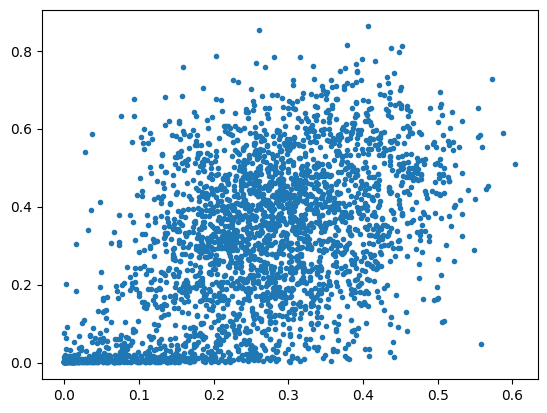

In [117]:
plt.plot(allsamples_pred[:,:,seifeatures[1].str.strip().values=='H3K4me3'].mean(axis=-1).mean(0),
        testseqs_pred[:,seifeatures[1].str.strip().values=='H3K4me3'].mean(axis=-1),'.')

In [120]:
acc = []
for i in range(5):
    acc.append(((allsamples_predh3k4me3[i] - testseqs_predh3k4me3)**2).mean())
np.mean(acc), np.std(acc)/np.sqrt(4)

(np.float64(0.041252179138817534), np.float64(0.00023528122120453413))

In [128]:
acc = []
for i in range(5):
    acc.append(((allsamples2x_predh3k4me3[i] - testseqs_predh3k4me3)**2).mean())
np.mean(acc), np.std(acc)/np.sqrt(4)

(np.float64(0.04067288056936634), np.float64(0.00043297744190450417))

In [ ]:
acc = []
for i in range(5):
    acc.append(((allsamples4x_predh3k4me3[i] - testseqs_predh3k4me3)**2).mean())
np.mean(acc), np.std(acc)/np.sqrt(4)

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R 
require(scales)
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(1, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}
scale_fill_Publication <- function(...){
      discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}
scale_colour_Publication <- function(...){
      discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

In [ ]:
%%R -i testseqs_predh3k4me3,allsamples_predh3k4me3,exp -w 10 -h 6 --unit in --res 300
require(ggplot2)

cutp <- function(x){
    cut(x, breaks=c(quantile(x, probs = seq(0, 1, by = 0.10))), include.lowest = T,
    labels=c("0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"))
}

print(table(cutp(log10(1+exp))))
plotdata = rbind(data.frame(x=cutp(log10(1+exp)), y=testseqs_predh3k4me3/0.004138, type='Human genome sequence'),
      data.frame(x=cutp(log10(1+exp)), y=allsamples_predh3k4me3[1,]/0.004138, type='Designed sequence'))
plotdata$type = factor(plotdata$type, levels=c('Human genome sequence', 'Designed sequence'))
p = ggplot(plotdata)+geom_boxplot(aes(x=x, y=y, fill=type),outlier.shape = NA)+
    ylab('Sequence promoter activity prediction \n (fold above baseline)') + xlab('Targeted promoter transcriptional activity for sequence generation (percentile)')+
    theme_Publication()+scale_fill_manual(values=c('gray','red'))+geom_hline(yintercept=1, linetype=2)
ggsave('compare_seqs.pdf', device=cairo_pdf)
p

In [ ]:
testseqs_scpred = testseqs_predh3k4me3
allsamples_scpred = allsamples_predh3k4me3
allsamples2x_scpred = allsamples2x_predh3k4me3

In [ ]:

%%R -i testseqs_scpred,allsamples_scpred,allsamples2x_scpred,exp -w 10 -h 6 --unit in --res 300
require(ggplot2)

cutp <- function(x){
    cut(x, breaks=c(quantile(x, probs = seq(0, 1, by = 0.10))), include.lowest = T,
    labels=c("0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"))
}

print(table(cutp(log10(1+exp))))
plotdata = rbind(data.frame(x=cutp(log10(1+exp)), y=testseqs_scpred/0.004138, type='Human genome sequence'),
      data.frame(x=rep(cutp(log10(1+exp)),each=5), y=as.numeric(allsamples_scpred)/0.004138, type='Designed sequence'),
       data.frame(x=rep(cutp(log10(1+exp)),each=5), y=as.numeric(allsamples2x_scpred)/0.004138, type='Designed sequence (2x time dilation)'))
plotdata$type = factor(plotdata$type, levels=c('Human genome sequence', 'Designed sequence','Designed sequence (2x time dilation)'))
p = ggplot(plotdata)+geom_boxplot(aes(x=x, y=y, fill=type),outlier.shape = NA)+
    ylab('Sequence promoter activity prediction \n (fold above baseline)') + xlab('Targeted promoter transcriptional activity for sequence generation (percentile)')+
    theme_Publication()+scale_fill_manual(values=c('gray','red','purple'))+geom_hline(yintercept=1, linetype=2)
ggsave('compare_seqs2.pdf', device=cairo_pdf)
p

In [ ]:
sample_bp = allsamples[0,:,:,:].mean(axis=0)
testseqs_bp = testseqs.mean(axis=0)

In [ ]:
sample_bp2x = allsamples2x[0,:2915,:,:].mean(axis=0)

In [ ]:
%%R -i sample_bp,testseqs_bp -w 10 -h 4 --unit in --res 300
require(ggplot2)
require(reshape2)
colnames(sample_bp) = c('A','C','G','T')
colnames(testseqs_bp) = c('A','C','G','T')
plotdata = rbind(cbind(melt(sample_bp),type='Designed promoter sequences'), 
                 cbind(melt(testseqs_bp),type='Human genome promoter sequences'))

p=ggplot(plotdata) + geom_line(aes(x=Var1-512, y=value, color=Var2))+theme_Publication()+scale_colour_Publication()+
    facet_wrap(~type,nrow=2)+xlab('Relative position (basepair)') + ylab('Proportion')
# ggsave('./figures/seqs_bp.pdf', device=cairo_pdf)
p

In [ ]:
%%R -i sample_bp,sample_bp2x,testseqs_bp -w 10 -h 6 --unit in --res 300
require(ggplot2)
require(reshape2)
colnames(sample_bp) = c('A','C','G','T')
colnames(sample_bp2x) = c('A','C','G','T')
colnames(testseqs_bp) = c('A','C','G','T')
plotdata = rbind(cbind(melt(sample_bp),type='Designed promoter sequences'), 
                 cbind(melt(sample_bp2x),type='Designed promoter sequences (2x time-dilation, time-dilation start time 25%)'), 
                 cbind(melt(testseqs_bp),type='Human genome promoter sequences'))

p=ggplot(plotdata) + geom_line(aes(x=Var1-512, y=value, color=Var2))+theme_Publication()+scale_colour_Publication()+
    facet_wrap(~type,nrow=3)+xlab('Relative position (basepair)') + ylab('Proportion')
# ggsave('./figures/seqs_bp2.pdf', device=cairo_pdf)
p

In [ ]:
all_bpds = 0.
all_items = 0

min_time = timepoints[0]
max_time = timepoints[-1]

logliks = []
loglikxs = []
qlogs  = []
all_bpds_l = []

for batch in test_datasets:
    cur_bpds = []
    
    for _ in range(10):
        s = batch[...,4:5]
        x = batch[...,:4]

        perturbed_x, _ = diffusion_factory(x.cpu(), torch.zeros(x.shape[0]).long(), v_one, v_zero,v_one_loggrad, v_zero_loggrad, alpha, beta)
        #perturbed_x, _ = diffusion_fast_flatdirichlet(x.cpu(), min_time, v_one, v_one_loggrad)

        perturbed_x = perturbed_x.to(device)
        x = x.to(device)
        v = sb._inverse(x, prevent_nan=False)
        perturbed_v = sb._inverse(perturbed_x, prevent_nan=False)

        z, loglik = ode_likelihood(perturbed_v, score_model, eps=1e-8, min_time=min_time, max_time=max_time,
                    device=device, alpha=None, beta=None, concat_input=s.cuda()) 
        N = np.prod(x.shape[1:-1]) 
        loglik = loglik / N
        loglikx = ( torch.log(torch.clip(perturbed_x, min=1e-8)) * (x==1)).sum(-1).mean(-1)

        torch.set_default_dtype(torch.float64)

        with torch.no_grad():
            qlog = jacobi_diffusion_density(v.double(), perturbed_v.double(), min_time.double(), alpha.to(device), beta.to(device), order=1000).log()

        for i, (a,b) in enumerate(zip(alpha.to(device), beta.to(device))):
            B = Beta(a, b)
            nanmask = torch.isnan(qlog[...,i])
            qlog[..., i][nanmask] = B.log_prob(perturbed_v[...,i][nanmask].double())

        qlog = (qlog.sum(-1)+sb.log_abs_det_jacobian(perturbed_v)).float().mean(-1)

        #qlog and loglikx  does not depdend on the model, so this is presampled to speed things up
        #note this is only for this dataset and this setup
        torch.set_default_dtype(torch.float32)

        elbo = loglik + loglikx - qlog
        logliks.append(loglik.cpu().detach().numpy())
        loglikxs.append(loglikx.cpu().detach().numpy())
        qlogs.append(qlog.cpu().detach().numpy())

        bpd = -(elbo.cpu().detach().numpy()) / np.log(2)
        cur_bpds.append((-(elbo.cpu().detach().numpy()) / np.log(2))[None,:])
        all_bpds += bpd.sum()
        all_items += bpd.shape[0]
        print("Average bits: {:5f}".format(all_bpds / all_items))
        print("Average nats: {:5f}".format(all_bpds / all_items *  np.log(2)))
        if np.isnan(all_bpds):
            break
    all_bpds_l.append(np.mean(np.concatenate(cur_bpds, axis=0), axis=0))


In [ ]:
bpds1 = np.concatenate(all_bpds_l, axis=0)

In [ ]:
%%R -i exp,bpds1  -w 7.5 -h 4 --unit in --res 300
cutp <- function(x){
    cut(x, breaks=c(quantile(x, probs = seq(0, 1, by = 0.10))), include.lowest = T,
    labels=c("0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"))
}
qplot(cutp(exp), bpds1, geom='boxplot', notch=T, outlier.shape=NA)+
    theme_Publication()+ylab('NLL (bits per dimension)')+xlab('Promoter expression level (percentile)')
# ggsave('./figures/seqs_nll.pdf', device=cairo_pdf)
